# P&D ISSP - Base notebook
@Students: You are free to edit anything you want.

Packages

In [1]:
import matplotlib
import soundfile
import os
import package.general as genfcns
import package.gui_utils as guifcns
matplotlib.style.use('default')  # <-- for notebooks: white figures background

# Root path (path to where you are storing this very notebook)
#  /!/  Adapt this to your system  /!/ 
ROOTPATH = 'C:/Users/uprub/Documents/PandD/pandd2023-base'

pathToSoundFiles = f'{ROOTPATH}/sound_files/'

# Parameters
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'speech2.wav'
]
noisefilenames = [
    pathToSoundFiles + 'Babble_noise1.wav'
]
signalDuration = 10     # [s]
muGSC = 0.1     # NLMS update constant for freq.-domain GSC

Build acoustic scenario and generate RIRs using GUI

In [51]:
# Launch GUI
guifcns.RIRg_GUI(
    exportFolder=f'{os.getcwd()}/rirs',
    outputRIRplot=False,
    distBwMics=10,  # [cm]
    fs=44100,
    t60=0,
    theme='SystemDefault',
)

[INVALID VALUE] Please enter a room dimension larger than 2 metres.
Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 10 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250306_213802.pkl.gz", in folder
"f:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\rirs"
You may close the GUI if not needed anymore!


Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[np.float64(7.0), np.float64(4.9)]]
>> Field "audioIds": ['64']
>> Field "c": 340
>> Field "distBwMics": 0.05
>> Field "exportFolder": f:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]
>> Field "micCoords": [[np.float64(9.05), np.float64(4.95)], [np.float64(9.05), np.float64(5.0)], [np.float64(9.05), np.float64(5.05)], [np.float64(9.05), np.float64(5.1)], [np.float64(9.05), np.float64(5.15)]]
>> Field "micsIds": ['59', '60', '61', '62', '63']
>> Field "nMicsPerArray": 5
>> Field "noiseCoords": [[np.float64(7.65), np.float64(3.55)]]
>> Field "noiseIds": ['65']
>> Field "numMics": 5
>> Field "rirLength": 

RIRs selection

(22050, 5, 1)


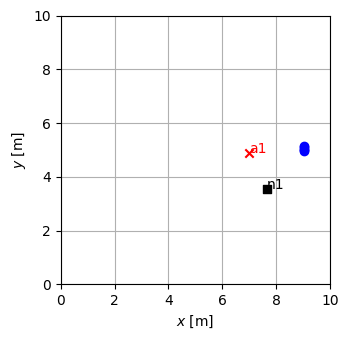

<Figure size 640x480 with 0 Axes>

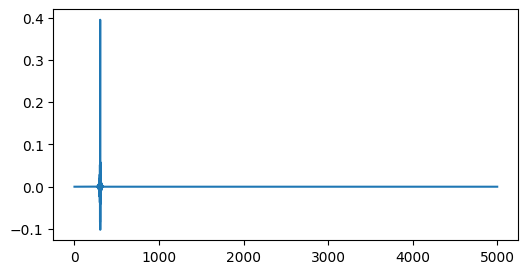

In [2]:
#Acoustic scenario first parts week 1
from package.gui_utils import load_rirs
current_rir = "C:/Users/uprub/Documents/PandD/pandd2023-base/rirs/week4_rvb.gz"
acousticScenario = load_rirs(path=current_rir) # loads the data
roomDim = acousticScenario.roomDim # access the room dimension [m]
print(acousticScenario) # print out all parameters

import matplotlib.pyplot as plt
# Select RIRs to be used
# rirFile = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
#rirFile = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
rirFile = current_rir
# Load from Pickle archive
acousticScenario = guifcns.load_rirs(path=rirFile)
# >>> NB: the RIRs can be accessed as acousticScenario.RIRsAudio /or/ RIRsNoise
acousticScenario.plot_asc()  # show the acoustic scenario as a pl

#Current angles are 45 and 135 degrees, and 14 degrees and 104 degrees
plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(acousticScenario.RIRsAudio[0:5000,1,0])
plt.title("RIR of source 1 to microphone 2")

# plt.figure()
# plt.figure(figsize=(6, 3))
# plt.plot(acousticScenario.RIRsNoise[:,0,0])
# print(acousticScenario.RIRsAudio.shape)
# print(acousticScenario)

# print(acousticScenario.RIRsAudio)
# print(acousticScenario.RIRsNoise.shape)
# print(acousticScenario)

(441000, 4)


<Figure size 640x480 with 0 Axes>

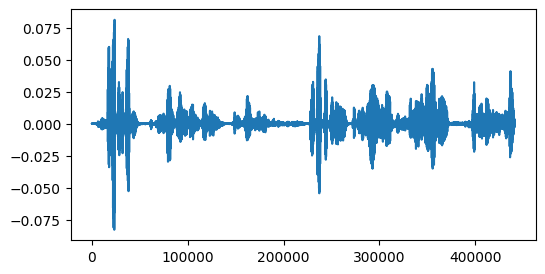

<Figure size 640x480 with 0 Axes>

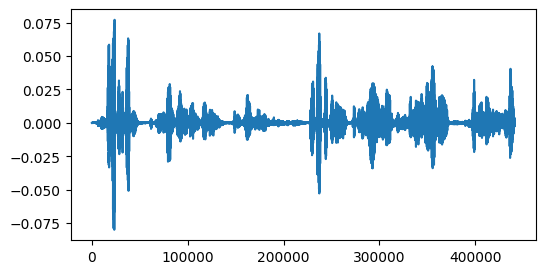

In [3]:
# Part 2
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(target_audio_files, noise_audio_files, acousticScenario, T_s, hmr_paths):
    
    if len(hmr_paths) == 0:
        num_micro = acousticScenario.RIRsAudio.shape[1]   # number of microphones
        # num_audio = acousticScenario.RIRsAudio.shape[2]   # number of audio sources
        # num_noise = acousticScenario.RIRsNoise.shape[2]   # number of noise sources
        fs = acousticScenario.fs
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)
        
        # Load and resample noise sources
        noise_components = []
        for file in noise_audio_files:
            noise, fs_noise = sf.read(file)
            noise_resampled = signal.resample(noise, int(len(noise) * fs / fs_noise)) if fs != fs_noise else noise
            noise_padded = np.pad(noise_resampled[:T_ds], (0, max(0, T_ds - len(noise_resampled))))
            noise_components.append(noise_padded)
        mic_signals = np.zeros((T_ds, num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = acousticScenario.RIRsAudio[:, mic_idx, audio_idx]
                #rir_speech /= np.max(np.abs(rir_speech))
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')
            for noise_idx, noise in enumerate(noise_components):
                rir_noise = acousticScenario.RIRsNoise[:, mic_idx, noise_idx]
                #rir_noise /= np.max(np.abs(rir_noise))
                mic_signal += signal.fftconvolve(noise, rir_noise, mode='same')

            mic_signals[:, mic_idx] = mic_signal
    else:
        all_paths = []
        for fpath in hmr_paths:
            all_paths.append([fpath + "/HMIR_L1.wav",fpath + "/HMIR_L2.wav",fpath + "/HMIR_R1.wav",fpath + "/HMIR_R2.wav"])
        fs = sf.read(all_paths[0][0])[1]
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        noise_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            fs = fs_audio
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)
        num_micro = 4
        mic_signals = np.zeros((T_ds, num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = sf.read(all_paths[audio_idx][mic_idx])[0]
                rir_speech /= np.max(np.abs(rir_speech))
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')
        
            mic_signals[:, mic_idx] = mic_signal
            
    

    # Plot first two microphone signals
    # for mic_idx in range(num_micro):
    #     plt.figure(figsize=(10, 4))
    #     plt.plot(mic_signals[:, mic_idx], label=f'Mic {mic_idx + 1}')
    #     plt.title(f"Microphone {mic_idx + 1} Signal")
    #     # plt.xlim((6425,6470))
    #     plt.xlabel("Samples")
    #     plt.ylabel("Amplitude")
    #     plt.legend()
    #     plt.show()
    
    return mic_signals, speech_components, noise_components, fs

hm_sources = ["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/head_mounted_rirs/s30"]
Time_duration = 5
mic, speech, noise, _ = create_micsigs(["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/whitenoise_signal_1.wav"], [], acousticScenario, Time_duration, [])
plt.figure(figsize=(10, 4))
plt.plot(mic[:, 0], label="Mic 1 Signal")
plt.plot(mic[:, 1], label="Mic 2 Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()


# sd.play(speech1[0:fs*1], fs)
# sd.play(mic[:,0], fs)

print(mic.shape)
# Play the first microphone signal
sd.play(mic[:, 0], samplerate=acousticScenario.fs)
sd.wait()  # Wait until playback finishes

In [ ]:
#Part 3 new
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def TDOA_corr(audio1_name, acousticScenario, Ts):
    """
    Estimate the Time Difference of Arrival (TDOA) using cross-correlation between two microphone signals.
    
    Args:
        audio1_name: Path to the white noise audio file.
        acousticScenario: Acoustic scenario object with RIRs and sampling frequency.
        Ts: Sampling period or time step.
    Returns:
        None
    """
    # Extract the RIRs for the two microphones
    rir1 = acousticScenario.RIRsAudio[:, 0, 0]  # RIR for mic 1
    rir2 = acousticScenario.RIRsAudio[:, 1, 0]  # RIR for mic 2
    
    # Identify the sample delay between the direct path components
    direct_path_idx1 = np.argmax(np.abs(rir1))  # Find the direct path peak for mic 1
    direct_path_idx2 = np.argmax(np.abs(rir2))  # Find the direct path peak for mic 2

    # Calculate the ground truth TDOA in seconds
    ground_truth_TDOA = (direct_path_idx1 - direct_path_idx2) / acousticScenario.fs
    print(f"Ground truth TDOA: {ground_truth_TDOA:.6f} seconds")

    # Generate the microphone signals from the scenario (using the provided create_micsigs function)
    mic_signals, _, _, _ = create_micsigs([audio1_name], [], acousticScenario, Ts, [])
    mic1 = mic_signals[:, 0]  # Signal from microphone 1
    mic2 = mic_signals[:, 1]  # Signal from microphone 2

    # Cross-correlation between the two microphone signals
    cross_corr = signal.correlate(mic1, mic2, mode="full")
    lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

    # Estimate the TDOA by finding the lag with the maximum correlation
    estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs
    print(f"Estimated TDOA: {estimated_TDOA:.6f} seconds")

    # Plot the time-domain cross-correlation function
    plt.figure(figsize=(8, 4))
    plt.plot(lags / acousticScenario.fs, cross_corr, label="Cross-correlation", color='b')
    
    # Plot the ground truth TDOA (as a red marker)
    plt.stem([ground_truth_TDOA], [np.max(cross_corr)], linefmt="r-", markerfmt="ro", basefmt="r-", label="Groundtruth")
    
    # Plot the estimated TDOA (as a green marker)
    plt.stem([estimated_TDOA], [np.max(cross_corr)], linefmt="g-", markerfmt="go", basefmt="g-", label="Estimated value")

    plt.xlabel("Time difference (seconds)")
    plt.ylabel("Cross-correlation amplitude")
    plt.legend()
    plt.title("TDOA Estimation via Cross-correlation")
    plt.xlim(-0.01, 0.01)  # Adjust the x-axis limit as necessary
    plt.grid(True)
    plt.show()

    # Print the difference between the estimated TDOA and the ground truth TDOA
    error = np.abs(estimated_TDOA - ground_truth_TDOA)
    print(f"TDOA estimation error: {error:.6f} seconds")
    
# Example usage
TDOA_corr("C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/whitenoise_signal_1.wav", acousticScenario, 5)


In [ ]:
#Part 4 new
import numpy as np
import scipy.signal as signal

def TDOA_corr(mic_signal_1, mic_signal_2, fs):
    """
    Estimate the Time Difference of Arrival (TDOA) using cross-correlation.
    
    Parameters:
    mic_signal_1, mic_signal_2 : numpy arrays
        Microphone signals.
    fs : int
        Sampling frequency in Hz.
    
    Returns:
    TDOA in seconds.
    """
    corr = signal.correlate(mic_signal_1, mic_signal_2, mode='full')
    lags = signal.correlation_lags(len(mic_signal_1), len(mic_signal_2), mode='full')
    
    max_lag = lags[np.argmax(corr)]
    TDOA = max_lag / fs  # Convert samples to time
    
    return TDOA

def DOA_corr(mic_signal_1, mic_signal_2, d, fs, c=340):
    """
    Estimate Direction of Arrival (DOA) using TDOA.
    
    Parameters:
    mic_signal_1, mic_signal_2 : numpy arrays
        Microphone signals.
    d : float
        Inter-microphone distance in meters.
    fs : int
        Sampling frequency in Hz.
    c : float, optional
        Speed of sound in m/s (default is 340 m/s).
    
    Returns:
    DOA estimate(s) in a Python list.
    """
    TDOA = TDOA_corr(mic_signal_1, mic_signal_2, fs)
    
    # Convert TDOA to DOA using the far-field model
    theta_rad = np.arccos((TDOA * c) / d)  # Angle in radians
    theta_deg = np.degrees(theta_rad)  # Convert to degrees
    
    # Ensure DOA is within [0, 180]
    theta_deg = np.clip(theta_deg, 0, 180)
    
    return [theta_deg]

# Reconstruct the first (non-reverberant) scenario of Part 2
fs = acousticScenario.fs  # Sampling frequency in Hz
d = acousticScenario.distBwMics  # Inter-microphone distance in meters

# Load a speech signal (assuming it is stored in a NumPy array)
# Replace 'speech_signal.npy' with the actual path to the speech signal file


mic_signals, _, _, _ = create_micsigs(["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/whitenoise_signal_1.wav"], [], acousticScenario, 5, [])
mic1 = mic_signals[:, 0]  # Signal from microphone 1
mic2 = mic_signals[:, 1]  # Signal from microphone 2


DOA_estimate = DOA_corr(mic1, mic2, d, fs)
print("Estimated DOA:", DOA_estimate[0])

In [ ]:
#Load in scenario for multisource:

#Acoustic scenario first parts week 1
from package.gui_utils import load_rirs
current_rir = "C:/Users/uprub/Documents/PandD/pandd2023-base/rirs/rirs_20250309_22h22m54s.pkl.gz"
acousticScenario = load_rirs(path=current_rir) # loads the data
roomDim = acousticScenario.roomDim # access the room dimension [m]
print(acousticScenario) # print out all parameters

import matplotlib.pyplot as plt
# Select RIRs to be used
# rirFile = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
#rirFile = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
rirFile = current_rir
# Load from Pickle archive
acousticScenario = guifcns.load_rirs(path=rirFile)
# >>> NB: the RIRs can be accessed as acousticScenario.RIRsAudio /or/ RIRsNoise
acousticScenario.plot_asc()  # show the acoustic scenario as a pl

#Current angles are 45 and 135 degrees, and 14 degrees and 104 degrees
plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(acousticScenario.RIRsAudio[0:5000,1,0])
plt.title("RIR of source 1 to microphone 2")

# plt.figure()
# plt.figure(figsize=(6, 3))
# plt.plot(acousticScenario.RIRsNoise[:,0,0])
# print(acousticScenario.RIRsAudio.shape)
# print(acousticScenario)

# print(acousticScenario.RIRsAudio)
# print(acousticScenario.RIRsNoise.shape)
# print(acousticScenario)

In [ ]:
# Part 5
def TDOA_corr_2(audio1_name, audio2_name, noise_name, acousticScenario, mic, Ts):
 rir1_1 = acousticScenario.RIRsAudio[:,mic[0],0]
 rir2_1 = acousticScenario.RIRsAudio[:,mic[1],0]

 direct_path_idx1_1 = np.argmax(np.abs(rir1_1))
 direct_path_idx2_1 = np.argmax(np.abs(rir2_1))

 ground_truth_TDOA_1 = (direct_path_idx1_1 - direct_path_idx2_1) / acousticScenario.fs

 print(f"Ground truth TDOA of source 1: {ground_truth_TDOA_1:.6f} seconds")

 rir1_2 = acousticScenario.RIRsAudio[:,mic[0],1]
 rir2_2 = acousticScenario.RIRsAudio[:,mic[1],1]

 direct_path_idx1_2 = np.argmax(np.abs(rir1_2))
 direct_path_idx2_2 = np.argmax(np.abs(rir2_2))

 ground_truth_TDOA_2 = (direct_path_idx1_2 - direct_path_idx2_2) / acousticScenario.fs

 print(f"Ground truth TDOA of source 2: {ground_truth_TDOA_2:.6f} seconds")

 mic_signals, _, _, _  = create_micsigs([audio1_name, audio2_name], [], acousticScenario, Ts, [])
 mic1 = mic_signals[:, 0] # Signal of the first mic
 mic2 = mic_signals[:, 1] # Signal of the second mic

 cross_corr = signal.correlate(mic1, mic2, mode="full")
 lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

 cross_corr /= np.max(np.abs(cross_corr))
 peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

 if len(peaks) < 2:
  raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")

 # Select the two highest peaks
 peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
 selected_peaks = peaks[peak_indices]

 TDOAestAll = []

 for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

 estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs

 print(f"First estimated TDOA: {TDOAestAll[1]:.6f} seconds")
 print(f"Second estimated TDOA: {TDOAestAll[0]:.6f} seconds")

 c = 340 # Speed of sound in air (m/s)
 mic_distance = acousticScenario.distBwMics
 TDOAestAll = np.array(TDOAestAll)
 cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
 cos_theta = np.clip(cos_theta, -1, 1)
 DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

 print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
 print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")
 return DOA_estimate

DOA_estimate = TDOA_corr_2("C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track1_dry.wav", "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track2_dry.wav", "", acousticScenario, [0, 1], 5)


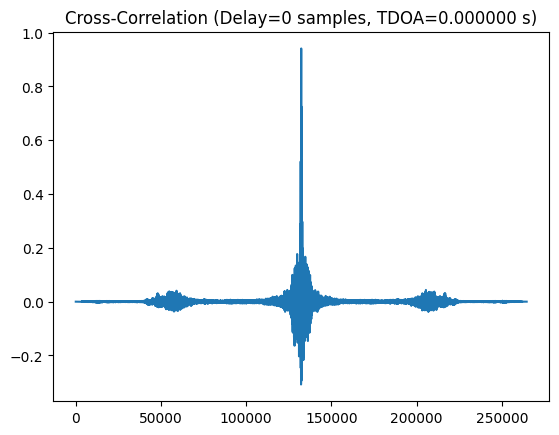

DOA estimate for HMIR_L1.wav & HMIR_L2.wav: 90.00°


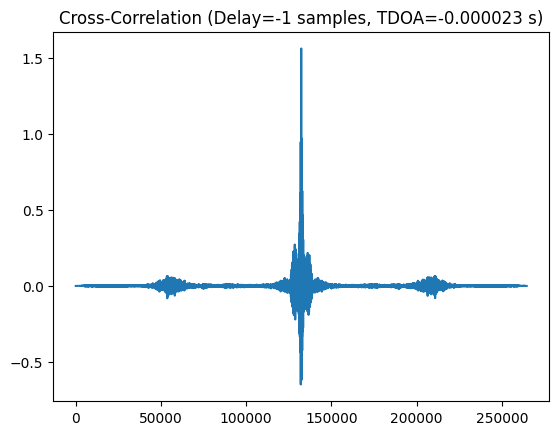

DOA estimate for HMIR_R1.wav & HMIR_R2.wav: 126.37°


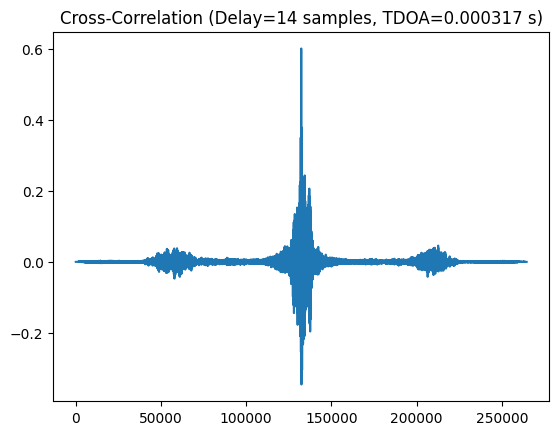

DOA estimate for HMIR_L1.wav & HMIR_R1.wav: 59.87°


In [71]:
# Part 6
import numpy as np
import soundfile as sf
import scipy.signal as sig
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('C:/Users/uprub/Documents/PandD/pandd2023-base/package')

from general import listen_to_array


def estimate_tdoa(mic1, mic2, fs, num_peaks=2):
    """Estimates the time differences of arrival (TDOAs) for up to two sources using cross-correlation."""
    if num_peaks == 2:
        """Estimates the time differences of arrival (TDOAs) for two sources, one positive and one negative, using cross-correlation."""
        corr = sig.correlate(mic1, mic2, mode='full')
        delays = sig.correlation_lags(len(mic1), len(mic2), mode='full')
        
        # Find peak indices in cross-correlation for both positive and negative lags
        peak_indices, _ = sig.find_peaks(np.abs(corr))  # Avoid detecting very close peaks
        peak_values = corr[peak_indices]
        
        # Separate the peaks into positive and negative lags
        positive_peak_indices = peak_indices[delays[peak_indices] > 0]
        negative_peak_indices = peak_indices[delays[peak_indices] < 0]
        
        # Find the peak with the largest positive value (positive lag)
        positive_peak_index = positive_peak_indices[np.argmax(np.abs(corr[positive_peak_indices]))]
        # Find the peak with the largest negative value (negative lag)
        negative_peak_index = negative_peak_indices[np.argmax(np.abs(corr[negative_peak_indices]))]

        # Convert to time differences (TDOAs)
        tdoa_positive = delays[positive_peak_index] / fs
        tdoa_negative = delays[negative_peak_index] / fs
        
        # Plot cross-correlation with detected peaks
        plt.figure()
        plt.plot(delays / fs, np.abs(corr))
        plt.scatter([tdoa_positive, tdoa_negative], [corr[positive_peak_index], corr[negative_peak_index]], color='red', label="Detected Peaks")
        plt.xlabel("Time Delay (s)")
        plt.ylabel("Cross-Correlation")
        plt.title("Cross-Correlation Function with Detected Peaks")
        plt.xlim((-0.01, 0.01))
        plt.legend()
        plt.show()

        return [tdoa_positive, tdoa_negative]  # Return the TDOAs for both peaks
    else:
        corr = sig.correlate(mic1, mic2, mode='full')
        delays = sig.correlation_lags(len(mic1), len(mic2), mode='full')
        
        # Find peak indices in cross-correlation
        peak_indices, _ = sig.find_peaks(np.abs(corr))  # Avoid detecting very close peaks
        peak_values = corr[peak_indices]
        
        # Select the top 'num_peaks' largest peaks by absolute value
        abs_peak_values = np.abs(peak_values)  # Get absolute values of peaks
        top_peaks = np.argsort(abs_peak_values)[-num_peaks:]  # Get indices of the two highest peaks by magnitude
        top_peaks = peak_indices[top_peaks]  # Convert to actual peak indices
        top_peaks = np.sort(top_peaks)  # Sort to maintain order
        
        tdoas = delays[top_peaks] / fs  # Convert to time (s)
        
        # Plot cross-correlation with peaks
        plt.figure()
        plt.plot(delays / fs, corr)
        plt.scatter(tdoas, corr[top_peaks], color='red', label="Detected Peaks")
        plt.xlabel("Time Delay (s)")
        plt.ylabel("Cross-Correlation")
        plt.title("Cross-Correlation Function with Detected Peaks")
        plt.xlim((-0.01, 0.01))
        plt.legend()
        plt.show()

        return tdoas  # Return list of detected TDOAs

def estimate_doa(tdoas, mic_spacing, c=340):
    """Converts TDOAs into DOA estimates for multiple sources."""
    doas = []
    for tdoa in tdoas:
        cos_theta = (tdoa * c) / mic_spacing
        cos_theta = np.clip(cos_theta, -1, 1)  # Ensure valid range
        theta = np.arccos(cos_theta) * (180 / np.pi)
        doas.append(theta)
    return doas  # Return list of DOAs

# Paths to impulse responses and target audio
rir_path = "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/head_mounted_rirs/s-60"
rir_path_2 = "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/head_mounted_rirs/s60"
audio_file = "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track1_dry.wav"
audio_file_2 = "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track2_dry.wav"
mic_signals, _, _, fs = create_micsigs([audio_file, audio_file_2], [], acousticScenario, 10, [rir_path, rir_path_2])
tdoa = estimate_tdoa(mic_signals[:, 0], mic_signals[:, 2], fs,2)
print(tdoa)
mic_spacing = 0.215 # 0.215 m for front ones and 0.013 m for the side ones
doa = estimate_doa(tdoa, mic_spacing)
print(doa)
for d in doa:
    print(doa)
binaural_signal = mic_signals[:, [0, 2]]  # Extract first and third columns
binaural_signal = np.ascontiguousarray(binaural_signal)  # Make sure it's contiguous


print()
# Play the binaural signal
#listen_to_array(binaural_signal, fs)
#print(f"DOA estimate for L1 & L2: {doa:.2f}°")


# Signal processing - Week 2: MUSIC algorithm

In [1]:
import numpy as np

winLength = 1024 # Window length
# nSources = acousticScenario.RIRsAudio.shape[-1] +\
#     acousticScenario.RIRsNoise.shape[-1] # Number of sources
theta = np.arange(0, np.pi, step=np.pi / 360)  # angles to consider

print('Computing DOAs via freq.-domain MUSIC algorithm...')

DOAestAll = music_wideband(f, stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c)
# DOAestAll = np.zeros(nSources)  # default

# print(f'All estimated DOAs: {DOAestAll * 180 / np.pi}')
print(f'All estimated DOAs: {DOAestAll}')

# ------------------ DOA estimation performance check ------------------
# Automatic selection of the target DOA
DOAest, groundTruthDOAtalkers = genfcns.auto_choice_doa(
    DOAestAll, acousticScenario
)
# print(f'Selected estimated DOAs: {np.round(DOAest * 180 / np.pi, 2)}')
DOAest = np.flip(DOAestAll)
print(f'Selected estimated DOAs: {np.round(DOAest, 2)}')
print(f'Ground truth DOAs: {np.round(groundTruthDOAtalkers * 180 / np.pi, 2)}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
# print(f'Estimate error(s): {np.round((DOAest - groundTruthDOAtalkers) * 180/np.pi, 2)} deg.')
print(f'Estimate error(s): {DOAestAll - np.round(groundTruthDOAtalkers * 180 / np.pi, 2)} deg.')

Computing DOAs via freq.-domain MUSIC algorithm...


NameError: name 'music_wideband' is not defined

In [47]:
#frequency check
if acousticScenario.fs == 44100:
    print("Correct sampling frequency: 44.1 kHz")
else:
    raise ValueError(f"False: Incorrect sampling frequency, current sampling frequency {acousticScenario.fs} Hz")

Correct sampling frequency: 44.1 kHz


In [48]:
import numpy as np
from scipy.signal import stft

# parameters
fs = 44100            # sampling frequency
L = 1024              # window length
overlap = L // 2      # 50% overlap
mic_t = mic.T

f, t, stft_mics = stft(
    mic_t,
    fs=fs,
    window='hann',
    nperseg=L,
    noverlap=overlap,
    return_onesided=True,
    axis=1
)

print("STFT shape:", stft_mics.shape)


STFT shape: (4, 513, 432)


Execution Time of narrowband MUSIC: 0.004844 seconds


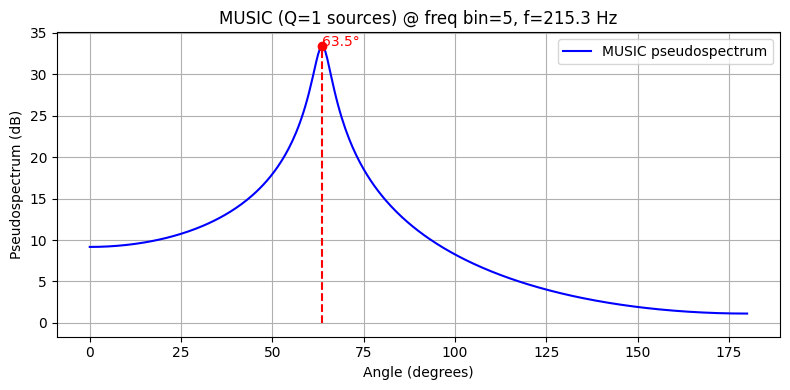

In [36]:
# narrowband
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import time

def music_narrowband(f, stft_mics, Q, d, c):
    start_time = time.time()   
    M, _, nT = stft_mics.shape
    
    power_per_bin = np.mean(np.abs(stft_mics)**2, axis=(0, 2))  # shape: (nF,)
    # power_per_bin[0] = 0  # Avoid DC bin
    fidx = np.argmax(power_per_bin) 
    f_bin = f[fidx]
    
    X_omega = stft_mics[:, fidx, :]  # shape: (M, nT)
    Rxx = (X_omega @ X_omega.conj().T) / nT  # (M, M)
    
    eigenvals, eigenvecs = np.linalg.eig(Rxx)
    sort_idx = np.argsort(eigenvals)       
    # eigenvals_sorted = eigenvals[sort_idx]
    eigenvecs_sorted = eigenvecs[:, sort_idx]
    Un = eigenvecs_sorted[:, :M - Q]  # shape (M, M-Q)  

    theta_vals = np.arange(0, 180.5, 0.5)
    theta_rad = np.deg2rad(theta_vals)[None,:]
    k0 = 2 * np.pi * f_bin / c  # wave number
    P_music = []
    
    m_index = np.arange(M)[:, None]

    S = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))
    v = Un.conj().T @ S
    norm_v_sq = np.sum(np.abs(v)**2, axis=0)
    P_music = 1 / norm_v_sq
    
    peaks, _ = find_peaks(P_music, distance=5, prominence=0.1)
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_values_all = P_music[peaks]
        if len(peaks) < Q:
            topQ_idx = np.argsort(peak_values_all)[::-1]  
        else:
            topQ_idx = np.argsort(peak_values_all)[-Q:]  

        topQ_idx_sorted = topQ_idx[np.argsort(peak_values_all[topQ_idx])]  
        
        peak_indices = peaks[topQ_idx_sorted]
        doa_estimates = theta_vals[peak_indices]
    
    end_time = time.time()
    print(f"Execution Time of narrowband MUSIC: {end_time - start_time:.6f} seconds")
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(P_music), 'b-', label='MUSIC pseudospectrum')
    
    for idx in peak_indices:
        peak_angle = theta_vals[idx]
        peak_value = 10*np.log10(P_music[idx])
        plt.stem([peak_angle], [peak_value], linefmt='r--', markerfmt='ro', basefmt=" ")
        plt.text(peak_angle, peak_value, f"{peak_angle:.1f}°", color='red')
    
    plt.title(f"MUSIC (Q={Q} sources) @ freq bin={fidx}, f={f_bin:.1f} Hz")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Pseudospectrum (dB)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

doa_estimates = music_narrowband(f, stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)


Execution Time of wideband MUSIC: 0.252556 seconds


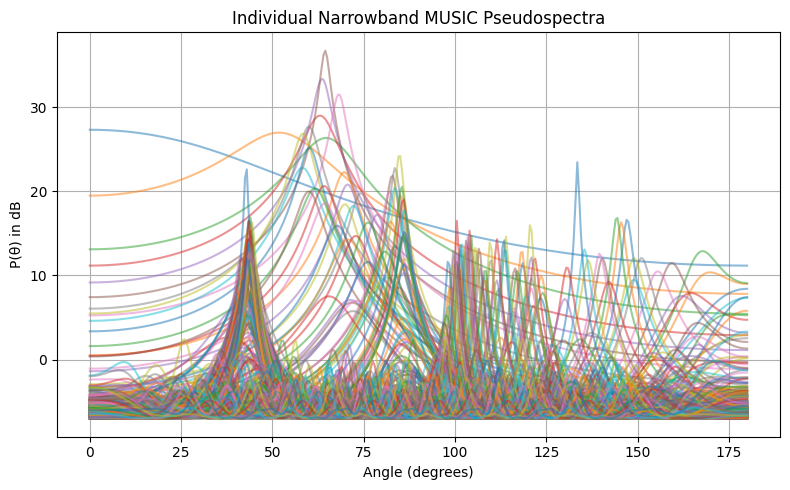

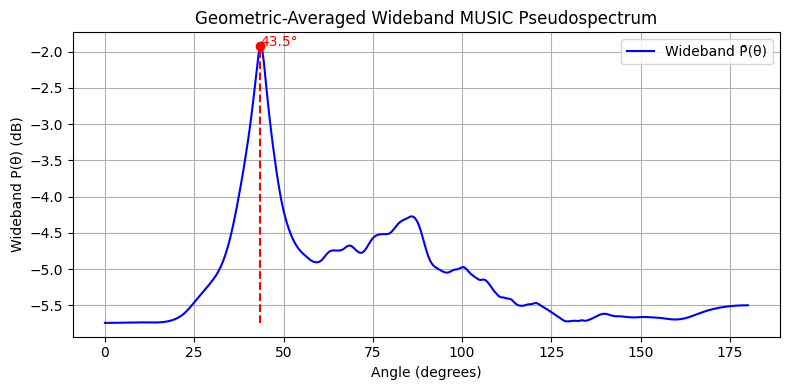

[43.5]


In [35]:
# wideband
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_wideband(f, stft_mics, Q, d, c):
    start_time = time.time() 
    M, nF, nT = stft_mics.shape
    
    theta_vals = np.arange(0, 180.5, 0.5)
    nTheta = len(theta_vals)
    
    freq_bins = range(1, nF-1)  
    nFreqUsed = len(freq_bins)
    
    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)

    theta_rad = np.deg2rad(theta_vals)            # (nTheta,)
    theta_rad = theta_rad[np.newaxis, :]          # (1, nTheta)
    m_index = np.arange(M)[:, np.newaxis]         # (M, 1)
    
    for i, fidx in enumerate(freq_bins):
        f_bin = f[fidx]
        
        X_omega = stft_mics[:, fidx, :]  # (M, nT)
        Rxx = (X_omega @ X_omega.conj().T) / nT
        
        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M-Q)]]  # (M, M-Q)
        
        k0 = 2 * np.pi * f_bin / c

        S = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))
        v = Un.conj().T @ S

        norm_v_sq = np.sum(np.abs(v)**2, axis=0)  # shape (nTheta,)
        pseudospec = 1.0 / norm_v_sq              # shape (nTheta,)

        all_pseudospec[i, :] = pseudospec.real
    
    
    
    log_all = np.log(all_pseudospec)  
    mean_log = np.mean(log_all, axis=0)      
    p_wideband = np.exp(mean_log)   # shape: (nTheta,)

    if Q==1:
        peaks = np.argmax(p_wideband)
        peaks = np.array([peaks])
    else:
        peaks, properties = find_peaks(
            p_wideband,
            distance=4,    
            prominence=0.05,  
            height=0.5 * np.max(p_wideband)  # 过滤掉小于 60% 最大值的峰
        )
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]
        else:
            idx_top = np.argsort(peak_vals)  
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]


    end_time = time.time()
    print(f"Execution Time of wideband MUSIC: {end_time - start_time:.6f} seconds") 

    plt.figure(figsize=(8,5))
    for i in range(nFreqUsed):
        plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]), alpha=0.5, label=f"bin {freq_bins[i]}")
    plt.title("Individual Narrowband MUSIC Pseudospectra")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("P(θ) in dB")
    plt.grid(True)
    # plt.legend(loc='best', ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show() 
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    plt.grid(True)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Wideband P(θ) (dB)")
    plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")
    
    for doa in doa_estimates:
        val_db = 10*np.log10(p_wideband[theta_vals==doa])
        plt.plot(doa, val_db, 'ro')
        plt.vlines(doa, min(10*np.log10(p_wideband)), val_db, color='r', linestyles='--')
        plt.text(doa, val_db, f"{doa:.1f}°", color='red')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    doa_estimates = 180 - doa_estimates
    return doa_estimates

c = 340

doa_estimates_wideband = music_wideband(f, stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c)
print(doa_estimates_wideband)


Execution Time of HM MUSIC: 0.157570 seconds


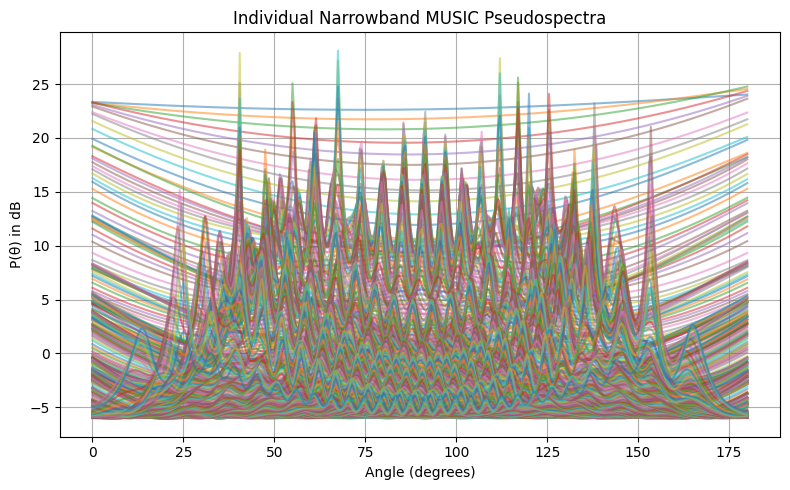

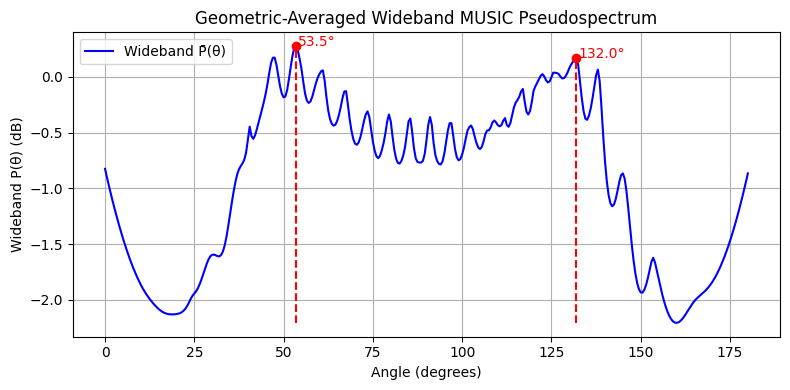

(4, 2)
[132.   53.5]


In [49]:
# Head-mounted
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import time

def music_wideband_HM(f, stft_mics, Q, c, mic_positions):
    start_time = time.time() 
    
    M, nF, nT = stft_mics.shape

    theta_vals = np.arange(-5, 185.5, 0.5) 
    nTheta = len(theta_vals)

    freq_bins = range(1, nF - 1)
    nFreqUsed = len(freq_bins)

    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)

    theta_rad = np.deg2rad(theta_vals)       # shape (nTheta,)
    cos_theta = np.cos(theta_rad)[np.newaxis, :]  # (1, nTheta)
    sin_theta = np.sin(theta_rad)[np.newaxis, :]  # (1, nTheta)

    x_mic = mic_positions[:, 0][:, np.newaxis]   # (M,1)
    y_mic = mic_positions[:, 1][:, np.newaxis]   # (M,1)

    for i, fidx in enumerate(freq_bins):
        f_bin = f[fidx]

        X_omega = stft_mics[:, fidx, :]
        Rxx = (X_omega @ X_omega.conj().T) / nT

        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M - Q)]]  # (M, M-Q)

        k0 = 2 * np.pi * f_bin / c
        phase = k0 * (x_mic * cos_theta + y_mic * sin_theta)

        S = np.exp(-1j * phase)
        v = Un.conj().T @ S

        norm_v_sq = np.sum(np.abs(v)**2, axis=0)
        pseudospec = 1 / norm_v_sq

        all_pseudospec[i, :] = pseudospec.real  

    log_all = np.log(all_pseudospec)         # shape: (nFreqUsed, nTheta)
    mean_log = np.mean(log_all, axis=0)     # shape: (nTheta,)
    p_wideband = np.exp(mean_log)           # (nTheta,)

    peaks, _ = find_peaks(
        p_wideband,
        distance=20,    # 20*0.5 = 10°
        prominence=0.07
        # height=0.6*np.max(p_wideband) 
    )

    # if p_wideband[0] > 0.7*np.max(p_wideband):
    #     peaks = np.append(peaks, 0)
    # if p_wideband[-1] > 0.7*np.max(p_wideband):
    #     peaks = np.append(peaks, -1)

    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]
        else:
            idx_top = np.argsort(peak_vals)
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]

    end_time = time.time()
    print(f"Execution Time of HM MUSIC: {end_time - start_time:.6f} seconds")

    plt.figure(figsize=(8,5))
    for i in range(nFreqUsed):
        plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]),
                 alpha=0.5, label=f"bin {freq_bins[i]}")
    plt.title("Individual Narrowband MUSIC Pseudospectra")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("P(θ) in dB")
    plt.grid(True)
    plt.tight_layout()
    plt.show() 

    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    plt.grid(True)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Wideband P(θ) (dB)")
    plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")

    for doa in doa_estimates:
        idx = np.where(theta_vals == doa)[0][0]
        val_db = 10*np.log10(p_wideband[idx])
        plt.plot(doa, val_db, 'ro')
        plt.vlines(doa, min(10*np.log10(p_wideband)), val_db,
                   color='r', linestyles='--')
        plt.text(doa + 0.5, val_db, f"{doa:.1f}°", color='red')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return doa_estimates

mic_positions = np.array([
    [0, 0   ],  # L1
    [0, -0.013],  # L2
    [0.215, 0],   # R1
    [0.215, -0.013]  # R2
    # [0, 0.4]
])
c = 340

doa_estimates_wideband = music_wideband_HM(f, stft_mics, 2, c, mic_positions)

print(doa_estimates_wideband)

# Week 3: DOA-informed Beamforming


In [ ]:
# Part 1
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(target_audio_files, noise_audio_files, acousticScenario, T_s, hmr_paths):
    # Check if fs is 44.1 kHz
    fs = acousticScenario.fs
    if fs != 44100:
        raise ValueError("Sampling frequency must be 44.1 kHz")

    if len(hmr_paths) == 0:
        
        num_micro = acousticScenario.RIRsAudio.shape[1]  # number of microphones
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)
        
        # Load and resample noise sources
        noise_components = []
        for file in noise_audio_files:
            noise, fs_noise = sf.read(file)
            
            noise_resampled = signal.resample(noise, int(len(noise) * fs / fs_noise)) if fs != fs_noise else noise
            noise_padded = np.pad(noise_resampled[:T_ds], (0, max(0, T_ds - len(noise_resampled))))
            noise_components.append(noise_padded)

        mic_signals = np.zeros((T_ds, num_micro))
        speech_3 = np.zeros((T_ds, 1))  # Placeholder for speech signal in the first mic
        noise_3 = np.zeros((T_ds, 1))  # Placeholder for noise in the first mic
        noise_sources_signal = np.zeros((T_ds, 1))  # Placeholder for noise sources in the first mic
        received_speech = np.zeros((T_ds, num_micro))
        
        received_noise = np.zeros((T_ds,num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = acousticScenario.RIRsAudio[:, mic_idx, audio_idx]
                #rir_speech /= np.max(np.abs(rir_speech))
                
                received_speech[:, mic_idx] += signal.fftconvolve(speech, rir_speech, mode='same')
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')

            for noise_idx, noise in enumerate(noise_components):
                rir_noise = acousticScenario.RIRsNoise[:, mic_idx, noise_idx]
                #rir_noise /= np.max(np.abs(rir_noise))
                received_noise[:, mic_idx] += signal.fftconvolve(noise, rir_noise, mode='same') 
                mic_signal += signal.fftconvolve(noise, rir_noise, mode='same')
                
                if mic_idx == 0:
                    noise_sources_signal[:, 0] += signal.fftconvolve(noise, rir_noise, mode='same')
            
            mic_signals[:, mic_idx] += mic_signal

            # Add noise to the first microphone signal
            if mic_idx == 0:
                vad = abs(received_speech[:,0]) > np.std(received_speech[:,0]) * 1e-3
                active_speech = received_speech[vad,0]
                P_speech = np.var(active_speech)
                P_noise_sources = np.var(noise_sources_signal[:, 0])
                noise_power = 0.1 * P_speech    # noise power
                
                # Add noise to the microphone signal
                i = 0
                for mic_idxx in range(num_micro):
                    i += 1
                    print("this is done", i, "times")
                    noise_signal = np.random.normal(0, np.sqrt(noise_power), len(speech_components[0]))
                    if (mic_idxx == 0):
                        noise_3[:, 0] = noise_signal  # Store additional noise signal    
                    mic_signals[:, mic_idxx] += noise_signal
                    received_noise[:, mic_idxx] += noise_signal
                    

        # Compute SNR for the first microphone
        P_noise_total = np.var(noise_3[:, 0]) + P_noise_sources
        SNR = 10 * np.log10(P_speech / P_noise_total)
        print(f"SNR in Mic 1: {SNR} dB")

    else:
        all_paths = []
        for fpath in hmr_paths:
            all_paths.append([fpath + "/HMIR_L1.wav", fpath + "/HMIR_L2.wav", fpath + "/HMIR_R1.wav", fpath + "/HMIR_R2.wav"])
        fs = sf.read(all_paths[0][0])[1]
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        noise_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            fs = fs_audio
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)

        num_micro = 4
        mic_signals = np.zeros((T_ds, num_micro))
        received_speech = np.zeros((T_ds, num_micro))
        received_noise = np.zeros((T_ds, num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = sf.read(all_paths[audio_idx][mic_idx])[0]
                rir_speech = rir_speech[0:int(0.005*fs)]    # truncate to prevent reverberation
                #rir_speech /= np.max(np.abs(rir_speech))
                received_speech[:, mic_idx] += signal.fftconvolve(speech, rir_speech, mode='same')
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')

            mic_signals[:, mic_idx] = mic_signal

    return mic_signals, received_speech, received_noise, fs


# Example usage
Time_duration = 10
mic, speech, noise, _ = create_micsigs(["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\speech1.wav"], ["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav"], acousticScenario, Time_duration, [])    # "F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav" ; "F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s-30"
comb = speech[5500:9000, 0] + noise[5500:9000, 0]
plt.figure(figsize=(10, 4))
plt.plot(mic[5500:9000, 0], label="Mic 1 Signal")
plt.plot(mic[5500:9000, 1], label="Mic 2 Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(noise[5500:9000, 0], label="noise Signal")
plt.plot(comb, label="original Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()

# Print shape of the microphone signals
print('Shape of mic:', mic.shape)
print('Shape of speech:',speech.shape)
print('Shape of noise:',noise.shape)
sd.play(mic[:, 3], samplerate=acousticScenario.fs)
# sd.wait()  # Wait until playback finishes
# sd.play(speech[:, 0], samplerate=acousticScenario.fs)

Execution Time of wideband MUSIC: 0.171967 seconds


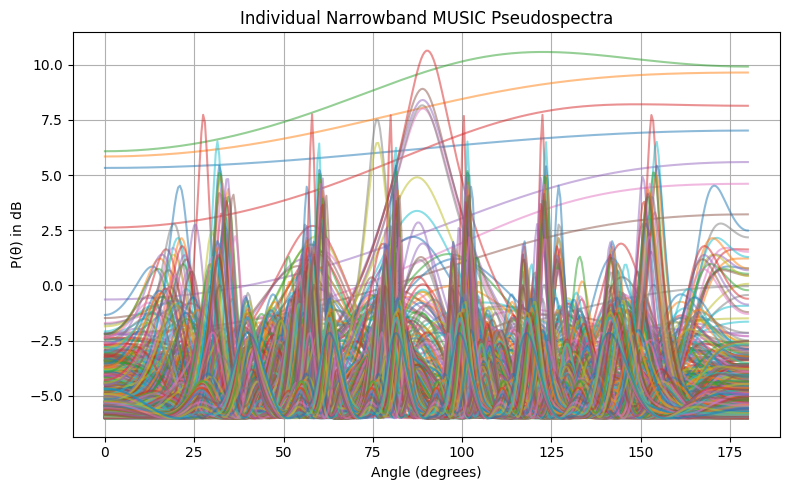

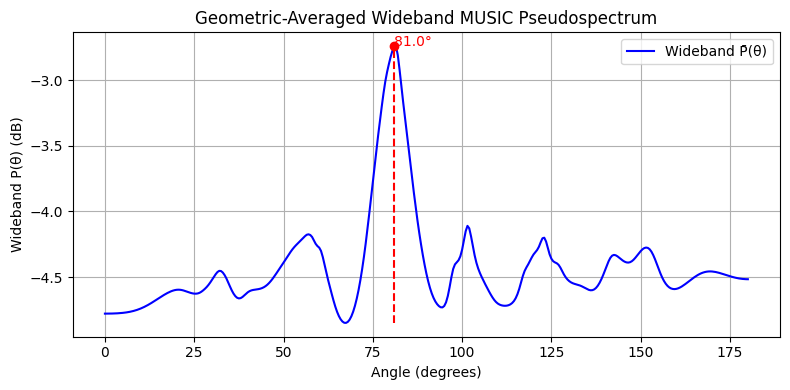

C:\Users\HeartUnderBlade\AppData\Local\Temp\ipykernel_9300\2545705464.py:89: RuntimeWarning: divide by zero encountered in scalar divide
  SNRoutDAS   = 10 * np.log10(sig_power / noise_power)


Execution Time of DAS: 1.003480 seconds


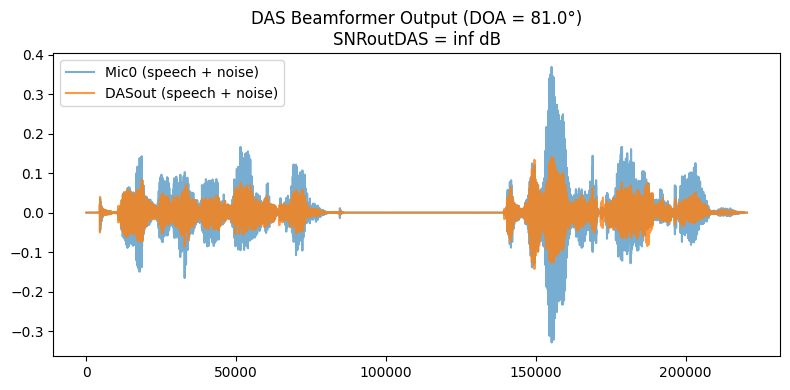

(220500,)
(220500,)
(220500,)
(220500, 4)


In [43]:
# beamforming
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def das_bf(mic, speech_component, noise_component, acousticScenario):
    start_time = time.time() 
    c = 340                     # speed of sound
    fs = acousticScenario.fs    # sampling frequency
    L = 1024                    # window length
    overlap = L // 2                # 50% overlap
    mic_t = mic.T

    f, _, stft_mics = stft(
        mic_t,
        fs=fs,
        window='hann',
        nperseg=L,
        noverlap=overlap,
        return_onesided=True,
        axis=1
    )

    DOA_est = music_wideband(f, stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c)

    target_index = np.argmin(np.abs(DOA_est - 90))
    target_angle = DOA_est[target_index]

    doa_deg = target_angle
    theta_rad = np.deg2rad(doa_deg)

    def delay_and_sum(signals, fs, dist, c, theta):
        N, M_ = signals.shape
        output = np.zeros(N)
        shifted_signals = np.zeros_like(signals)  # shape (N, M_)
        
        for m in range(M_):
            mic_pos = m * dist
            delay_secs = (mic_pos * np.cos(theta)) / c
            delay_samples = -int(round(delay_secs * fs))

            shifted = np.zeros_like(signals[:, m])
            if delay_samples >= 0:
                if delay_samples >= N:
                    pass
                else:
                    shifted[delay_samples:] = signals[:(N-delay_samples), m]
            else:
                dly = -delay_samples
                if dly >= N:
                    pass
                else:
                    shifted[:N-dly] = signals[dly:, m]
            
            shifted_signals[:, m] = shifted
            output += shifted 
        return output, shifted_signals
    
    speechDAS, speechDAS_seperate = delay_and_sum(speech_component, fs, acousticScenario.distBwMics, c, theta_rad)
    noiseDAS, noiseDAS_seperate = delay_and_sum(noise_component, fs, acousticScenario.distBwMics, c, theta_rad)

    DASout = speechDAS + noiseDAS
    DASout_seperate = speechDAS_seperate + noiseDAS_seperate
    DASout /= mic.shape[1]
    
    # p_mic0_speech = np.var(speech[:, 0])
    # p_das_speech  = np.var(speechDAS)
    # if p_das_speech > 1e-12:
    # alpha = np.sqrt(p_mic0_speech / p_das_speech)
    # else:
    #     alpha = 1.0  
       
    # speechDAS *= alpha
    # noiseDAS  *= alpha
    # DASout    *= alpha
    # DASout_seperate *= alpha
 

    sig_power   = np.var(speechDAS)
    noise_power = np.var(noiseDAS) 
    SNRoutDAS   = 10 * np.log10(sig_power / noise_power)

    end_time = time.time()
    print(f"Execution Time of DAS: {end_time - start_time:.6f} seconds")

    plt.figure(figsize=(8,4))
    # plt.plot(speech[:,0], label="Mic0 (speech only)", alpha=0.6)
    plt.plot(mic[:,0], label="Mic0 (speech + noise)", alpha=0.6)
    plt.plot(DASout, label="DASout (speech + noise)", alpha=0.8)
    plt.title(f"DAS Beamformer Output (DOA = {doa_deg:.1f}°)\nSNRoutDAS = {SNRoutDAS:.2f} dB")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_seperate, noiseDAS_seperate
        
DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_seperate, noiseDAS_seperate = das_bf(mic, speech, noise, acousticScenario)

sd.play(DASout, samplerate=acousticScenario.fs)

Execution Time of wideband MUSIC: 0.215068 seconds


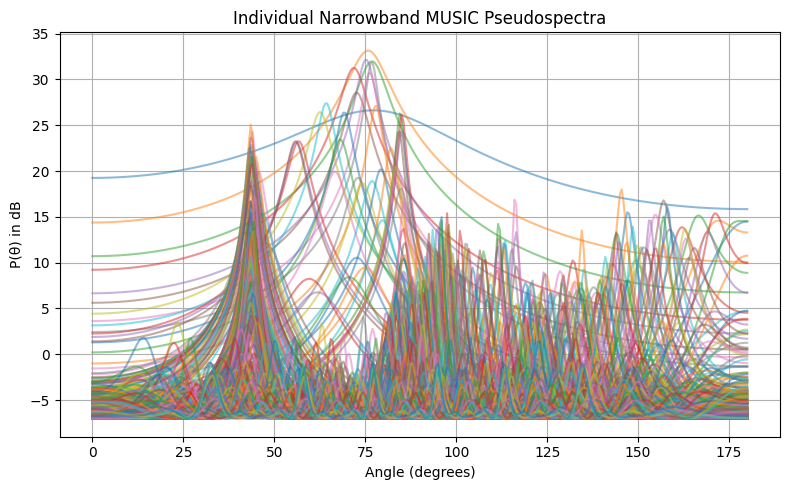

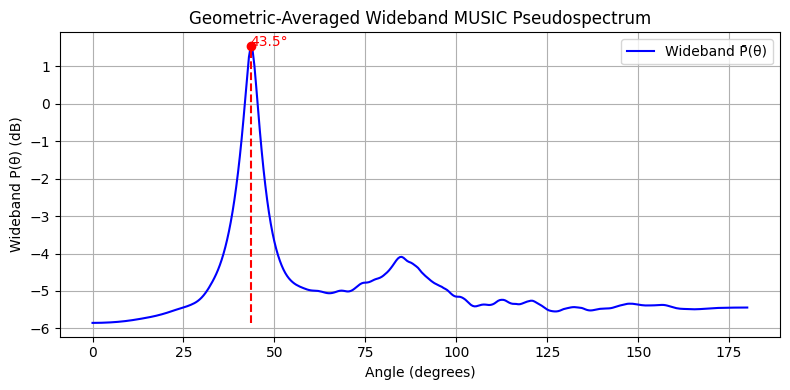

Execution Time of DAS: 1.178250 seconds


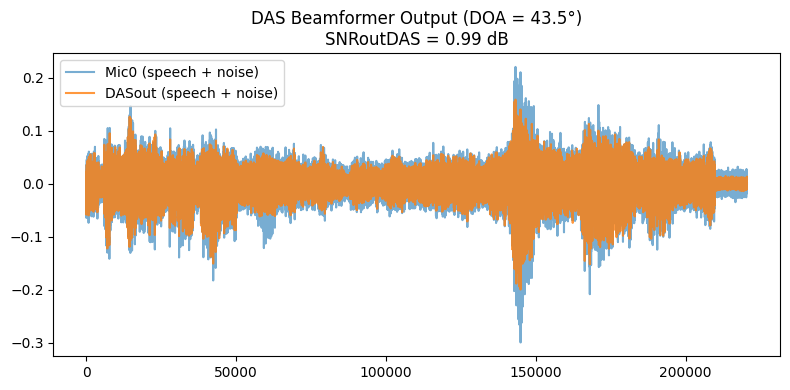

Execution Time of GSC: 6.790169 seconds


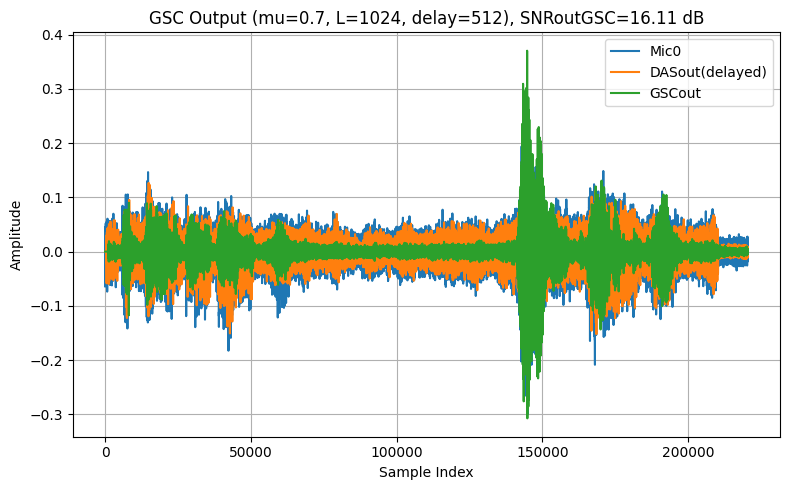

(220500, 1)


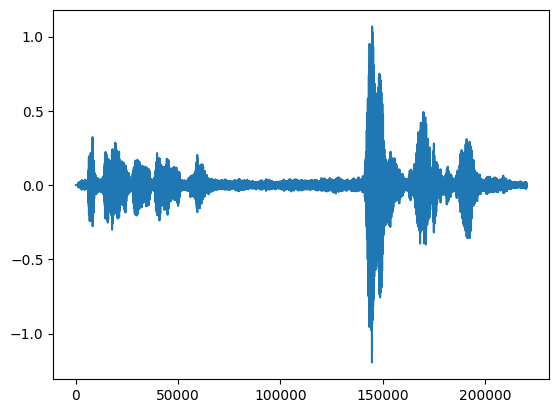

In [38]:
# GSC
import numpy as np
import matplotlib.pyplot as plt

def gsc_td(mic, speech_component, noise_component, acousticScenario, mu, L, Delta):
    start_time = time.time()

    DASout, speechDAS, _, _, DASout_aligned, noiseDAS_seperate = das_bf(mic, speech_component, noise_component,acousticScenario)
    N = len(DASout)
    
    M = mic.shape[1]
    B1 = -np.eye(M-1)
    B2 = np.ones((M-1,1))
    B = np.hstack((B2, B1)) # shape: (M-1, M)
    
    X_block = DASout_aligned @ B.T   # shape: (N, M-1)
    # X_block = noiseDAS_seperate[:,1:M]

    Das_delayed = np.zeros(N)
    Das_delayed[Delta:] = DASout[:N - Delta]
    
    W = np.zeros((L, M-1))
    GSCout = np.zeros((N, 1))
    # noise_est_out = np.zeros((N, 1))

    vad = abs(speechDAS) > np.std(speechDAS) * 1e-3
    
    for n in range(L, N):
        slice_block = X_block[n-L:n,:]
        len_slice = slice_block.shape[0]

        if len_slice < L:
            pad_length = L - len_slice 
            slice_block = np.pad(slice_block, ((0, pad_length), (0, 0)), mode='constant')

        noise_est_matrix = W.T @ slice_block
        noise_est = np.trace(noise_est_matrix)
        e_n = Das_delayed[n] - noise_est
        if vad[n] == 0:
            W += mu * e_n * slice_block / np.linalg.norm(slice_block, ord='fro')**2
        GSCout[n] = e_n
        # noise_est_out[n] = noise_est

    
    GSCout_active = GSCout[vad == 1,0]
    GSCout_noise = GSCout[vad == 0,0]
    GSCout_active_power = np.var(GSCout_active)
    GSCout_noise_power = np.var(GSCout_noise)
    SNRoutGSC = 10 * np.log10(GSCout_active_power / GSCout_noise_power)
    
    gsc_en = np.mean(GSCout**2)
    das_en = np.mean(Das_delayed**2)

    # if gsc_en > 1e-12:  
    alpha = np.sqrt(das_en / gsc_en)
    # else:
    #     alpha = 1.0

    GSCout = alpha * GSCout

    end_time = time.time()
    print(f"Execution Time of GSC: {end_time - start_time:.6f} seconds")

    fs = acousticScenario.fs
    time_axis = np.arange(len(mic[:, 0])) / fs

    plt.figure(figsize=(12,5))
    plt.plot(time_axis, mic[:,0], label='Mic0')
    plt.plot(time_axis, Das_delayed, label="DASout")
    plt.plot(time_axis, GSCout, label='GSCout')
    # plt.plot(speechDAS, label='DAS-speech-only', alpha=0.7)
    # plt.title(f"GSC Output (mu={mu}, L={L}, delay={Delta}), SNRoutGSC={SNRoutGSC:.2f} dB")
    plt.title(f"GSC Output")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return GSCout, SNRoutGSC, X_block   # noise_est_out, DASout, DASout_aligned


mu = 0.5
L = 1024
Delta = int(L/2)
GSCout, SNRoutGSC, X_block = gsc_td(mic, speech, noise, acousticScenario, mu, L, Delta)


In [39]:
sd.play(GSCout, samplerate=acousticScenario.fs)
# sd.play(X_block[:,1], samplerate=acousticScenario.fs)
# plt.figure()
# plt.plot(X_block)

Execution Time of HM MUSIC: 0.169779 seconds


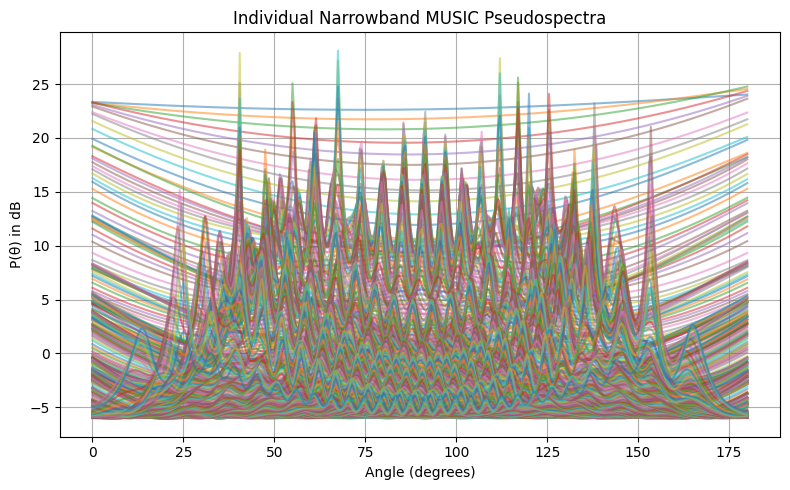

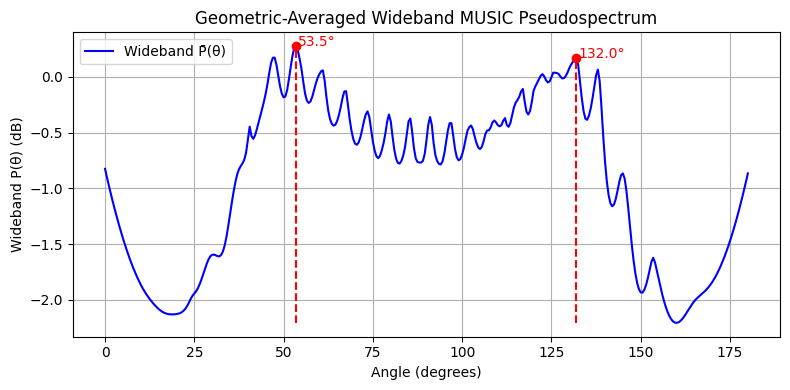

C:\Users\HeartUnderBlade\AppData\Local\Temp\ipykernel_9300\3297990445.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  SNRoutDAS   = 10 * np.log10(sig_power / noise_power)


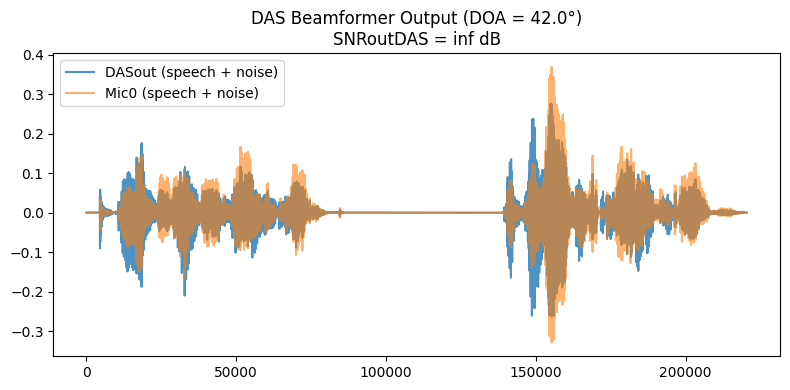

Execution Time of HM GSC: 8.114204 seconds


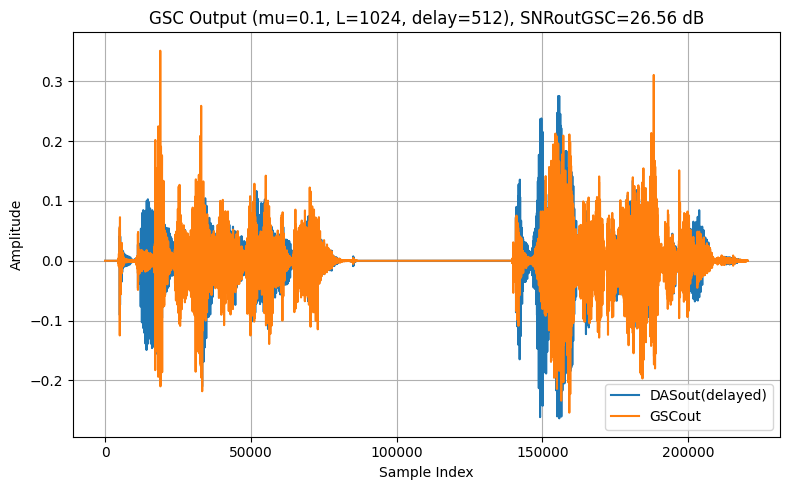

In [44]:
# Head-mounted case
import numpy as np
import matplotlib.pyplot as plt

def das_bf_HM(mic, speech_component, noise_component, mic_positions):
    c = 340                     # speed of sound
    fs = 44100    # sampling frequency
    L = 1024                    # window length
    overlap = L // 2                # 50% overlap

    mic_t = mic.T

    f, _, stft_mics = stft(
        mic_t,
        fs=fs,
        window='hann',
        nperseg=L,
        noverlap=overlap,
        return_onesided=True,
        axis=1
    )

    DOA_est = music_wideband_HM(f, stft_mics, 2, c, mic_positions)

    DOA_est[0] = DOA_est[0] - 90
    DOA_est[1] = DOA_est[1] + 90

    target_index = np.argmin(np.abs(DOA_est - 90))
    target_angle = DOA_est[target_index]

    doa_deg = target_angle
    theta_rad = np.deg2rad(doa_deg)

    def delay_and_sum(signals, fs, mic_positions, c, theta):
        N, M_ = signals.shape
        output = np.zeros(N)
        shifted_signals = np.zeros_like(signals)  # shape (N, M_)
        
        for m in range(M_):
            x_m, y_m = mic_positions[m]
            delay_secs = (x_m * np.cos(theta) + y_m * np.sin(theta)) / c

            delay_samples = int(round(delay_secs * fs))

            shifted = np.zeros_like(signals[:, m])
            if delay_samples >= 0:
                if delay_samples >= N:
                    pass
                else:
                    shifted[delay_samples:] = signals[:(N-delay_samples), m]
            else:
                dly = -delay_samples
                if dly >= N:
                    pass
                else:
                    shifted[:N-dly] = signals[dly:, m]
            
            shifted_signals[:, m] = shifted
            output += shifted 
        return output, shifted_signals
    
    speechDAS, speechDAS_seperate = delay_and_sum(speech_component, fs, mic_positions, c, theta_rad)
    noiseDAS, noiseDAS_seperate = delay_and_sum(noise_component, fs, mic_positions, c, theta_rad)

    DASout = speechDAS + noiseDAS
    DASout_seperate = speechDAS_seperate + noiseDAS_seperate

    p_mic0_speech = np.var(speech[:, 0])
    p_das_speech  = np.var(speechDAS)
    alpha = np.sqrt(p_mic0_speech / p_das_speech)
    
    speechDAS *= alpha
    noiseDAS  *= alpha
    DASout    *= alpha
    DASout_seperate *= alpha

    sig_power   = np.var(speechDAS)
    noise_power = np.var(noiseDAS)
    # if noise_power < 1e-12:
    #     noise_power = 1e-12
    SNRoutDAS   = 10 * np.log10(sig_power / noise_power)

    plt.figure(figsize=(8,4))
    # plt.plot(speech[:,0], label="Mic0 (speech only)", alpha=0.6)
    plt.plot(DASout, label="DASout (speech + noise)", alpha=0.8)
    plt.plot(mic[:,0], label="Mic0 (speech + noise)", alpha=0.6)
    plt.title(f"DAS Beamformer Output (DOA = {doa_deg:.1f}°)\nSNRoutDAS = {SNRoutDAS:.2f} dB")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_seperate



def gsc_td_HM(mic, speech_component, noise_component, mic_positions, mu, L, Delta):
    start_time = time.time()
    DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_aligned = das_bf_HM(mic, speech_component, noise_component, mic_positions)
    N = len(DASout)
    
    M = mic.shape[1]
    B1 = -np.eye(M-1)
    B2 = np.ones((M-1,1))
    B = np.hstack((B2, B1)) # B.shape: (M-1, M)
    
    X_block = DASout_aligned @ B.T   # shape: (N, M-1)

    Das_delayed = np.zeros(N)
    Das_delayed[Delta:] = DASout[:N - Delta]
    
    W = np.zeros((L, M-1))
    GSCout = np.zeros((N, 1))

    vad = abs(speechDAS) > np.std(speechDAS) * 1e-3
    
    for n in range(L, N):
        slice_block = X_block[n-L:n,:]
        len_slice = slice_block.shape[0]

        if len_slice < L:
            pad_length = L - len_slice 
            slice_block = np.pad(slice_block, ((0, pad_length), (0, 0)), mode='constant')

        noise_est_matrix = W.T @ slice_block
        noise_est = np.trace(noise_est_matrix)
        e_n = Das_delayed[n] - noise_est
        if vad[n] == 0:
            W += mu * e_n * slice_block / np.linalg.norm(slice_block, ord='fro')**2
        GSCout[n] = e_n
    
    GSCout_active = GSCout[vad == 1,0]
    GSCout_noise = GSCout[vad == 0,0]
    GSCout_active_power = np.var(GSCout_active)
    GSCout_noise_power = np.var(GSCout_noise)
    SNRoutGSC = 10 * np.log10(GSCout_active_power / GSCout_noise_power)

    gsc_en = np.var(GSCout)
    das_en = np.var(Das_delayed)

    # if gsc_en > 1e-12:  
    alpha = np.sqrt(das_en / gsc_en)
    # else:
    #     alpha = 1.0
    GSCout = alpha * GSCout

    end_time = time.time()
    print(f"Execution Time of HM GSC: {end_time - start_time:.6f} seconds")
    


    plt.figure(figsize=(8,5))
    # plt.plot(mic[:,0], label='DASout')
    plt.plot(Das_delayed, label="DASout(delayed)")
    plt.plot(GSCout, label='GSCout')
    # plt.plot(speechDAS, label='DAS-speech-only', alpha=0.7)
    plt.title(f"GSC Output (mu={mu}, L={L}, delay={Delta}), SNRoutGSC={SNRoutGSC:.2f} dB")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return GSCout, SNRoutGSC, X_block


mu = 0.1
L = 1024
Delta = int(L/2)
mic_positions = np.array([
    [0, 0   ],  # L1
    [0, -0.013],  # L2
    [0.215, 0],   # R1
    [0.215, -0.013]  # R2
    # [0, 0.4]
])

# DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_seperate = das_bf_HM(mic, speech, noise, mic_positions)
# print(DASout.shape)
# print(speechDAS.shape)
# print(noiseDAS.shape)
# print(DASout_seperate.shape)

# sd.play(DASout, samplerate=acousticScenario.fs)

GSCout, SNRoutGSC, X_block = gsc_td_HM(mic, speech, noise, mic_positions, mu, L, Delta)



In [45]:
sd.play(GSCout, samplerate=acousticScenario.fs)
# sd.play(X_block[:,0], samplerate=acousticScenario.fs)

# Signal processing - Week 4: Frequency-domain GSC

In [ ]:
#Loading rirs
from package.gui_utils import load_rirs
current_rir = "C:/Users/uprub/Documents/PandD/pandd2023-base/rirs/week4_rvb.gz"
acousticScenario = load_rirs(path=current_rir) # loads the data
roomDim = acousticScenario.roomDim # access the room dimension [m]
print(acousticScenario) # print out all parameters

#plotting rirs
import matplotlib.pyplot as plt
# Select RIRs to be used
# rirFile = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
#rirFile = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
rirFile = current_rir
# Load from Pickle archive
acousticScenario = guifcns.load_rirs(path=rirFile)
# >>> NB: the RIRs can be accessed as acousticScenario.RIRsAudio /or/ RIRsNoise
acousticScenario.plot_asc()  # show the acoustic scenario as a pl

#Current angles are 45 and 135 degrees, and 14 degrees and 104 degrees
plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(acousticScenario.RIRsAudio[0:5000,1,0])
plt.title("RIR of source 1 to microphone 2")

# plt.figure()
# plt.figure(figsize=(6, 3))
# plt.plot(acousticScenario.RIRsNoise[:,0,0])
# print(acousticScenario.RIRsAudio.shape)
# print(acousticScenario)

# print(acousticScenario.RIRsAudio)
# print(acousticScenario.RIRsNoise.shape)
# print(acousticScenario)

In [ ]:
#Adjusting mic sigs for this week:
import sys
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd
from scipy.signal import stft
sys.path.append('C:/Users/uprub/Documents/PandD/pandd2023-base/package')
from general import listen_to_array, oracle_choice_doa

def create_micsigs(target_audio_files, noise_audio_files, acousticScenario, position_s,position_in, T_s, start, P_noise_mic_1):
    # Check if fs is 44.1 kHz
    fs = acousticScenario.fs
    if fs != 44100:
        raise ValueError("Sampling frequency must be 44.1 kHz")
        
    num_micro = acousticScenario.RIRsAudio.shape[1]  # number of microphones
    T_ds = int(T_s * fs)

    # Load and resample target audio sources
    speech_components = []
    for file in target_audio_files:
        speech, fs_audio = sf.read(file)
        
        speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
        speech_padded = np.pad(speech_resampled[start:T_ds+start], (0, max(0, T_ds - len(speech_resampled))))
        speech_components.append(speech_padded)
    
    # Load and resample noise sources
    noise_components = []
    for file in noise_audio_files:
        noise, fs_noise = sf.read(file)
        
        noise_resampled = signal.resample(noise, int(len(noise) * fs / fs_noise)) if fs != fs_noise else noise
        noise_padded = np.pad(noise_resampled[:T_ds], (0, max(0, T_ds - len(noise_resampled))))
        noise_components.append(noise_padded)

    mic_signals = np.zeros((T_ds, num_micro))
    speech_3 = np.zeros((T_ds, 1))  # Placeholder for speech signal in the first mic
    noise_3 = np.zeros((T_ds, 1))  # Placeholder for noise in the first mic
    noise_sources_signal = np.zeros((T_ds, 1))  # Placeholder for noise sources in the first mic
    received_speech = np.zeros((T_ds, num_micro))
    
    received_noise = np.zeros((T_ds,num_micro))
    for mic_idx in range(num_micro):
        mic_signal = np.zeros(T_ds)
        
        rir_speech = acousticScenario.RIRsAudio[:, mic_idx, position_s]
        #rir_speech /= np.max(np.abs(rir_speech))
        
        received_speech[:, mic_idx] += signal.fftconvolve(speech_components[0], rir_speech, mode='same')
        mic_signal += signal.fftconvolve(speech_components[0], rir_speech, mode='same')

        rir_noise = acousticScenario.RIRsAudio[:, mic_idx, position_in]
        #rir_noise /= np.max(np.abs(rir_noise))
        received_noise[:, mic_idx] += signal.fftconvolve(speech_components[1], rir_noise, mode='same') 
        mic_signal += signal.fftconvolve(speech_components[1], rir_noise, mode='same')
        
        if mic_idx == 0:
            noise_sources_signal[:, 0] += signal.fftconvolve(speech_components[1], rir_noise, mode='same')
        
        mic_signals[:, mic_idx] += mic_signal

        # Add noise to the first microphone signal
        if mic_idx == 0:
            vad = abs(received_speech[:,0]) > np.std(received_speech[:,0]) * 1e-3
            active_speech = received_speech[vad,0]
            P_speech = np.var(active_speech)
            P_noise_sources = np.var(noise_sources_signal[:, 0])
            if (P_noise_mic_1 == 0):
                noise_power = 0.0001 * P_speech
            else:
                noise_power = P_noise_mic_1
            
            

            # Add noise to the microphone signal
            #i = 0
            for mic_idxx in range(num_micro):
                print(range(num_micro))
                #i += 1
                #print("this is done", i, "times")
                noise_signal = np.random.normal(0, np.sqrt(noise_power), len(speech_components[0]))
                if (mic_idxx == 0):
                    noise_3[:, 0] = noise_signal  # Store additional noise signal
                mic_signals[:, mic_idxx] += noise_signal
                received_noise[:, mic_idxx] += noise_signal
                

    # Compute SNR for the first microphone
    P_noise_total = np.var(noise_3[:, 0]) + P_noise_sources
    SNR = 10 * np.log10(P_speech / P_noise_total)
    print(f"SNR in Mic 1: {SNR} dB")

    return mic_signals, received_speech, received_noise, fs, noise_power

# wideband
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_wideband(f, stft_mics, Q, d, c):
    M, nF, nT = stft_mics.shape
    
    theta_vals = np.arange(0, 180.5, 0.5)
    nTheta = len(theta_vals)
    
    freq_bins = range(1, nF-1)  
    nFreqUsed = len(freq_bins)
    
    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)

    theta_rad = np.deg2rad(theta_vals)            # (nTheta,)
    theta_rad = theta_rad[np.newaxis, :]          # (1, nTheta)
    m_index = np.arange(M)[:, np.newaxis]         # (M, 1)
    
    for i, fidx in enumerate(freq_bins):
        f_bin = f[fidx]
        
        X_omega = stft_mics[:, fidx, :]  # (M, nT)
        Rxx = (X_omega @ X_omega.conj().T) / nT
        
        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M-Q)]]  # (M, M-Q)
        
        k0 = 2 * np.pi * f_bin / c

        S = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))
        v = Un.conj().T @ S

        norm_v_sq = np.sum(np.abs(v)**2, axis=0)  # shape (nTheta,)
        pseudospec = 1.0 / norm_v_sq              # shape (nTheta,)

        all_pseudospec[i, :] = pseudospec.real
    
    # plt.figure(figsize=(8,5))
    # for i in range(nFreqUsed):
    #     plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]), alpha=0.5, label=f"bin {freq_bins[i]}")
    # plt.title("Individual Narrowband MUSIC Pseudospectra")
    # plt.xlabel("Angle (degrees)")
    # plt.ylabel("P(θ) in dB")
    # plt.grid(True)
    # # plt.legend(loc='best', ncol=2, fontsize='small')
    # plt.tight_layout()
    # plt.show()
    
    log_all = np.log(all_pseudospec)  
    mean_log = np.mean(log_all, axis=0)      
    p_wideband = np.exp(mean_log)   # shape: (nTheta,)

    if Q==1:
        peaks = np.argmax(p_wideband)
        peaks = np.array([peaks])
    else:
        peaks, properties = find_peaks(
            p_wideband,
            distance=4,    
            prominence=0.02,  
            height=0.1 * np.max(p_wideband)  # 过滤掉小于 60% 最大值的峰
        )
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]
        else:
            idx_top = np.argsort(peak_vals)  
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]  
    
    # plt.figure(figsize=(8,4))
    # plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    # plt.grid(True)
    # plt.xlabel("Angle (degrees)")
    # plt.ylabel("Wideband P(θ) (dB)")
    # plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")
    
    # for doa in doa_estimates:
    #     val_db = 10*np.log10(p_wideband[theta_vals==doa])
    #     plt.plot(doa, val_db, 'ro')
    #     plt.vlines(doa, min(10*np.log10(p_wideband)), val_db, color='r', linestyles='--')
    #     plt.text(doa, val_db, f"{doa:.1f}°", color='red')
    
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    
    return doa_estimates

# Example usage
#Time_duration = 5
target_audio_files = ["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track1_dry.wav","C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track2_dry.wav"]
noise_audio_files = []
angles = np.array([10.6, 31.1,50.1,63.4,80.7])  # Only two angles alternating
audio_src_idx = [0,4]
interf_src_idx = [5,9]
segment_duration = 10  # seconds
num_segments = len(audio_src_idx)  # Number of alternating position segments
doa_update_interval = 10  # Update DOA every 10 frames

mic_signals_list = []

for i in range(num_segments):
    audio_idx_now = audio_src_idx[i]
    interf_idx_now = interf_src_idx[i]
    start = i * segment_duration * acousticScenario.fs
    if (i==0):
        mic, speech, noise, _, noisp = create_micsigs(target_audio_files, noise_audio_files, acousticScenario, audio_idx_now,interf_idx_now, segment_duration, start, 0)
    else:
        mic, speech, noise, _, _ = create_micsigs(target_audio_files, noise_audio_files, acousticScenario, audio_idx_now,interf_idx_now, segment_duration, start, noisp)
    mic_signals_list.append(mic)
mic = np.concatenate(mic_signals_list, axis=0)  # Concatenate all segments
comb = speech[5500:9000, 0] + noise[5500:9000, 0]
plt.figure(figsize=(10, 4))
plt.plot(mic[5500:9000, 0], label="Mic 1 Signal")
plt.plot(mic[5500:9000, 1], label="Mic 2 Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(noise[5500:9000, 0], label="noise Signal")
plt.plot(comb, label="original Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()

# Print shape of the microphone signals
print(mic.shape)
print(speech.shape)
print(noise.shape)
binaural_signal = mic[:, [0, 2]]  # Extract first and third columns
binaural_signal = np.ascontiguousarray(binaural_signal)
#listen_to_array(binaural_signal, acousticScenario.fs)
#sd.play(mic[:, 0], samplerate=acousticScenario.fs)
#sd.wait()  # Wait until playback finishes

# parameters
fs = 44100         # sampling frequency
L = 512           # window length
hop = L // 2       # 50% overlap
M = mic.shape[1]   # number of microphones
n_samples = mic.shape[0]  # number of samples

stft_mics_list = []

for m in range(M):
    mic_signal = mic[:, m]
    
    f, t, Zxx = stft(mic_signal,
                     fs=fs,
                     window='hann',   # 'hann', 'boxcar'
                     nperseg=L,
                     noverlap=hop,
                     return_onesided=True)

    stft_mics_list.append(Zxx)  # shape: (nF, nT)

stft_mics = np.array(stft_mics_list)  # (M, nF, nT)
print(stft_mics.shape)

print("stft_mics shape:", stft_mics.shape)
doa_estimates = music_wideband(f,stft_mics[:,:,1500:1800], 2, acousticScenario.distBwMics, c=340)
exact_doa = oracle_choice_doa([],acousticScenario)
print(exact_doa * (360/(2*np.pi)))

In [ ]:
import numpy as np
import scipy.signal as signal
import scipy.linalg as linalg
import numpy as np
import scipy.signal as signal
import scipy.linalg as linalg
#OK
def stft_analysis(signal_data, window, hop_size, fft_size, fs):
    freq, _, spectrogram = signal.stft(signal_data.T, window=window, nperseg=fft_size, noverlap=hop_size, return_onesided=True, fs=fs)
    return freq, spectrogram
#OK
def inverse_stft_overlap_save(spectrogram, window, hop_size, fft_size):
    _, time_signal = signal.istft(spectrogram, window=window, nperseg=fft_size, noverlap=hop_size)
    
    # Create a synthesis window, typically a square-root Hanning window
    synthesis_window = window / np.sum(window[::hop_size])
    output_signal = np.zeros(time_signal.shape)
    
    # Process each frame
    num_frames = (time_signal.shape[0] - fft_size) // hop_size + 1
    for i in range(num_frames):
        start = i * hop_size
        # Multiply by the synthesis window for each frame
        output_signal[start:start + fft_size] += time_signal[start:start + fft_size] * synthesis_window
    
    return output_signal

#OK
def compute_steering_vector(RIRs, fft_size, doa):
    doa_idx = np.argmin(np.abs(RIRs['angles'] - doa))
    if (doa_idx < 5):
        RIRm = RIRs['rir_set'][:,:,doa_idx]
    else:
        raise ValueError("Error with angle determination")
        print("idx is ", doa_idx)
    H = np.fft.rfft(RIRm, n=fft_size, axis=0)

    H_ref = H[:, 0]
    H_ref[H_ref == 0] = 1e-10  # Avoid division by zero
    return H / H_ref[:, np.newaxis]
#OK
def fas_beamformer(steering_vector):
    return steering_vector / (steering_vector.conj().T @ steering_vector)
#OK
def blocking_matrix(steering_vector):
    steering_vector = steering_vector.reshape(-1, 1)  # Reshape to (M,1)
    nullspace = linalg.null_space(steering_vector.T)
    return nullspace.T
#NOK
def nlms_filter(desired, interference, filter_coeffs, mu=0.1, epsilon=1e-6, mu_min=0.05, mu_max=0.5):
    # Compute the current input signal norm
    x_vec = interference
    norm_factor = np.dot(x_vec.conj(), x_vec) + epsilon
    
    # Compute the error between the desired signal and filter output
    error = desired - np.dot(filter_coeffs.conj(), x_vec)
    
    # Adapt the learning rate based on the current error
    # Optionally, use the absolute value of the error or other criteria to adjust mu
    #error_norm = np.abs(error)
    #mu = np.clip(mu * (1 + error_norm / (norm_factor + epsilon)), mu_min, mu_max)  # Adaptive update of mu
    
    # Update the filter coefficients
    filter_coeffs += (mu / norm_factor) * error * x_vec
    
    # Apply leakage to prevent drift
    filter_coeffs *= 0.99
    
    return error, filter_coeffs



def gsc_fd(mic_signals, RIRs, window, hop_size, fft_size, distBwMics, c, fs, doa_update_interval,time_frame_calc, noise_sigs, speech_sigs):
    freq, spectrograms = stft_analysis(mic_signals, window, hop_size, fft_size, fs)
    freq_n, spectrograms_n = stft_analysis(noise_sigs, window, hop_size, fft_size, fs)
    freq_s, spectrograms_s = stft_analysis(speech_sigs, window, hop_size, fft_size, fs)
    num_time_frames = spectrograms.shape[2]
    output_spectrogram = np.zeros_like(spectrograms[0, :, :], dtype=np.complex64)
    output_spectrogram_FAS = np.zeros_like(spectrograms[0, :, :], dtype=np.complex64)
    output_noise_spectrogram = np.zeros_like(spectrograms_n[0, :, :], dtype=np.complex64)
    output_speech_spectrogram = np.zeros_like(spectrograms_s[0, :, :], dtype=np.complex64)
    doa_estimate = None
    learning_rate = 0.15
    filter_coeffs = np.zeros((mic_signals.shape[1] - 1, freq.shape[0]), dtype=np.complex64)  # Initialize once and keep updating
    for t_idx in range(num_time_frames):
        if (t_idx < time_frame_calc):
            output_spectrogram[:, t_idx] = spectrograms[0,:, t_idx]
            output_noise_spectrogram[:, t_idx] = spectrograms_n[0,:, t_idx]
            output_speech_spectrogram[:, t_idx] = spectrograms_s[0,:, t_idx]
        else:
            if t_idx % doa_update_interval == 0 or doa_estimate is None:
                old_doa = doa_estimate
                doa_estimate = music_wideband(freq, spectrograms[:, :, t_idx-time_frame_calc:t_idx], 2, distBwMics, c)[0]
                doa_estimate = 0.7 * doa_estimate + 0.3 * old_doa if old_doa is not None else doa_estimate
                steering_vectors = compute_steering_vector(RIRs, fft_size, doa_estimate)
            for f_idx in range(spectrograms.shape[1]):
                steering_vector = steering_vectors[f_idx, :]
                w_fas = fas_beamformer(steering_vector)
                B = blocking_matrix(steering_vector)
                # print(B @ steering_vector)
                y_gsc = w_fas.conj().T @ spectrograms[:,f_idx, t_idx]
                y_gsc_n = w_fas.conj().T @ spectrograms_n[:,f_idx, t_idx]
                y_gsc_s = w_fas.conj().T @ spectrograms_s[:,f_idx, t_idx]
                interference = B @ spectrograms[:,f_idx, t_idx] # B is (M,N) so interference is (N,)
                interference_n = B @ spectrograms_n[:,f_idx, t_idx]
                interference_s = B @ spectrograms_s[:,f_idx, t_idx]
                
                # Calculate the total error (speech + noise) between the actual signal and filter output
        

                
                adaptive_output, filter_coeffs_f = nlms_filter(y_gsc, interference, filter_coeffs[:, f_idx], mu=learning_rate)
                adaptive_output_n, _ = nlms_filter(y_gsc_n, interference_n, filter_coeffs[:, f_idx], mu=learning_rate)
                adaptive_output_s, _ = nlms_filter(y_gsc_s, interference_s, filter_coeffs[:, f_idx], mu=learning_rate)

                # Normalize filter coefficients to prevent divergence
                #filter_coeffs_f /= (np.linalg.norm(filter_coeffs_f) + 1e-6)  # Avoid division by zero


                output_spectrogram[f_idx, t_idx] = adaptive_output
                output_spectrogram_FAS[f_idx, t_idx] = y_gsc
                output_noise_spectrogram[f_idx, t_idx] = adaptive_output_n
                output_speech_spectrogram[f_idx, t_idx] = adaptive_output_s

                # Update the weights for this frequency bin
                alpha = 0.5
                filter_coeffs[:, f_idx] = filter_coeffs_f * alpha + filter_coeffs[:, f_idx] * (1 - alpha)
            
    
    return inverse_stft_overlap_save(output_spectrogram, window, hop_size, fft_size), inverse_stft_overlap_save(output_noise_spectrogram, window, hop_size, fft_size), inverse_stft_overlap_save(output_speech_spectrogram, window, hop_size, fft_size), inverse_stft_overlap_save(output_spectrogram_FAS, window, hop_size, fft_size)

# Example usage
fft_size = 800
hop_size = fft_size // 2
window = np.sqrt(signal.windows.hann(fft_size))
c = 340
fs = 44100


target_audio_files = ["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track1_dry.wav","C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track2_dry.wav"]
noise_audio_files = []
angles = np.array([10.6,31.1, 50.1,63.4,80.7])  # Only two angles alternating
audio_src_idx = [1,2,3]
interf_src_idx = [6,7,8]
segment_duration = 10  # seconds
num_segments = 3  # Number of alternating position segments
doa_update_interval = 10  # Update DOA every 10 frames
time_frame_calc = 100

mic_signals_list = []
speech_signals_list = []
noise_signals_list = []

for i in range(num_segments):
    audio_idx_now = audio_src_idx[i]
    interf_idx_now = interf_src_idx[i]
    start = i * segment_duration * acousticScenario.fs
    if (i==0):
        mic, speech, noise, _, noisp = create_micsigs(target_audio_files, noise_audio_files, acousticScenario, audio_idx_now,interf_idx_now, segment_duration, start, 0)
    else:
        mic, speech, noise, _, _ = create_micsigs(target_audio_files, noise_audio_files, acousticScenario, audio_idx_now,interf_idx_now, segment_duration, start, noisp)

    mic_signals_list.append(mic)
    speech_signals_list.append(speech)
    noise_signals_list.append(noise)
mic_signals = np.concatenate(mic_signals_list, axis=0)  # Concatenate all segments
noise_signals = np.concatenate(noise_signals_list, axis=0)  # Concatenate all segments
speech_signals = np.concatenate(speech_signals_list, axis=0)  # Concatenate all segments
print(mic_signals.shape)

enhanced_signal, noise_part, speech_part, FAS_part = gsc_fd(mic_signals, {'rir_set': acousticScenario.RIRsAudio, 'angles': angles}, window, hop_size, fft_size, acousticScenario.distBwMics, c, fs, doa_update_interval,time_frame_calc, noise_signals, speech_signals)

print("Enhanced Signal Shape:", enhanced_signal.shape)

# Plot the 1D enhanced signal
plt.figure(figsize=(10, 6))
plt.plot(enhanced_signal)
plt.title('Enhanced Signal')
plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')

# Display the plot
plt.grid(True)
plt.show()



In [ ]:
# time_axis = np.arange(len(enhanced_signal)) / fs
# # Ensure time_axis matches the length of mic_signals[:, 0]
# time_axis = time_axis[:mic_signals.shape[0]]

# # Plot all three signals on the same figure
# plt.figure(figsize=(12, 6))

# # Plot the microphone signal (raw input)
# plt.plot(time_axis, mic_signals[:, 0], label="Microphone Signal", alpha=0.6)

# # Plot the enhanced signal (FAS output)
# plt.plot(time_axis, FAS_part[:mic_signals.shape[0]], label="FAS Output", alpha=0.7)

# # Plot the noise estimate (GSC output)
# plt.plot(time_axis, enhanced_signal[:mic_signals.shape[0]], label="GSC Output", alpha=0.9)

# # Labels and title
# plt.xlabel("Time [samples]")
# plt.ylabel("Amplitude")
# plt.title("Comparison of FAS Output, GSC Output, and Microphone Signal")
# plt.legend()
# plt.grid(True)
# plt.xlim((10.2,10.4))

# # Show the plot
# plt.show()

In [ ]:
sd.play(mic_signals[:,0], samplerate=acousticScenario.fs)
sd.wait()  # Wait until playback finishes
sd.play(enhanced_signal, samplerate=acousticScenario.fs)
sd.wait()  # Wait until playback finishes


In [ ]:
#Computer SIR part:

import numpy as np

def compute_sir(y, x1, x2, groundTruth):
    """
    Compute the signal-to-interference ratio for two sources (one target source
    and one interfering source). The script takes into account possible
    switches between which source is the target and which one is the
    interference. The script assumes there is access to each source's
    contribution in the beamformer output.

    Parameters
    ----------
    -y : [N x 1] np.ndarray[float]
        Actual beamformer output signal (`N` is the number of samples).
    -x1 : [N x 1] np.ndarray[float]
        Beamformer output attributed to source 1.
    -x2 : [N x 1] np.ndarray[float]
        Beamformer output attributed to source 2.
    -groundTruth : [N x 1] np.ndarray[int (0 or 1) or float (0. or 1.)]
        Array indicating, for each sample,
        which source is the target: 1=x1, 0=x2.

    Returns
    -------
    -sir : 
    """
    # Sanity check (check whether `y = x1 + x2` based on RMSE of residual)
    # if np.sqrt(np.sum((y - x1 - x2) ** 2)) / np.sqrt(np.sum(y ** 2)) > 0.01:
    #     print('/!\ Something is wrong, `y` should be the sum of `x1` and `x2`.')  
    #     print('SIR can not be computed -- Returning NaN.')  
    #     sir = np.nan
    # # Input check
    # elif np.sum(groundTruth) + np.sum(1 - groundTruth) != len(groundTruth):
    #     print('/!\ `groundTruth` vector is not binary.')
    #     print('SIR can not be computed')  
    #     sir = np.nan
    # else:
    sir = 10 * np.log10(
        np.var(x1 * groundTruth + x2 * (1 - groundTruth)) / np.var(x2 * groundTruth + x1 * (1 - groundTruth))
    )

    return sir
sir = compute_sir(enhanced_signal[300000:500000], speech_part[300000:500000], noise_part[300000:500000], np.ones_like(enhanced_signal[300000:500000]))
print(f"SIR: {sir:.2f} dB")
sir_original = compute_sir(mic_signals[300000:500000,0], speech_signals[300000:500000,0], noise_signals[300000:500000,0], np.ones_like(mic_signals[300000:500000,0]))
print(f"SIR: {sir_original:.2f} dB")